### Estimating Covariance and Expected Returns

The Cap-Weighted (CW) and Equally-Weighted (EW) portfolios have been backtested and they each have unique positions in industrial implementations.

CW portfolios are the overall average and hence the de-facto industry standard. They are very inexpensive to implement and feature very low turnover. In many ways, they are the default go-to implementation choice for many investors.

However, there have some disadvantages, so there is room for improvement.

EW is the most obvious improvement because they are the only other technique (that we are going to look at) other than CW that requires no estimation of either covariance or expected returns. The backtesting was done before and they are easier to build.

Now, to build more sophisticated portfolios which involve estimations, I'll start with CW and EW portfolios, since they are the baseline portfolios.

In [1]:
import numpy as np
import pandas as pd

import risk_kit as kit

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
ind_returns = kit.get_ind_returns(weighting='ew', n_inds=49)["1974":]
ind_returns.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01,0.1442,0.1365,0.1517,0.1152,0.0803,0.1952,0.1527,0.0891,0.1433,0.2033,...,0.1554,0.1419,0.1508,0.1425,0.1442,0.1096,0.0919,0.1981,0.0871,0.1110
1974-02,0.0720,0.0465,-0.0051,-0.0095,0.0175,0.0180,0.0138,-0.0097,0.0250,0.0127,...,0.0133,0.0625,0.0099,0.0046,-0.0084,0.0086,-0.0092,-0.0343,0.0129,0.0129
1974-03,-0.0084,0.0063,0.0143,-0.0053,-0.0700,0.0079,0.0113,0.0415,0.0179,0.0063,...,0.0682,0.0197,0.0260,0.0217,0.0705,-0.0003,-0.0112,-0.0040,-0.0004,0.0045
1974-04,-0.0735,-0.0421,-0.0660,-0.0597,-0.0258,-0.0480,-0.0446,-0.0361,-0.0667,-0.0470,...,-0.0057,-0.0511,-0.0426,-0.0516,-0.0672,-0.0470,-0.0605,-0.0899,-0.0663,-0.0494
1974-05,-0.0697,-0.0595,-0.0745,-0.0507,-0.0328,-0.0694,-0.0724,-0.0382,-0.0454,-0.0744,...,-0.0456,-0.0675,-0.0802,-0.0603,-0.0484,-0.1026,-0.0766,-0.1091,-0.0865,-0.0671


In [8]:
ind_returns.columns

Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero',
       'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm',
       'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips', 'LabEq', 'Paper', 'Boxes',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin',
       'Other'],
      dtype='object')

In [9]:
inds = list(ind_returns.columns)
#inds = ['Fin', 'Gold', 'Hlth', 'Food', 'Beer']

In [11]:
# Load market caps
ind_mcap = kit.get_ind_market_caps(49, weights=True)["1974":]

In [12]:
## Give different weighting functions and backtest the data.
ew_returns = kit.backtest_ws(ind_returns, estimation_window=36, weighting=kit.weight_ew)
cw_returns = kit.backtest_ws(ind_returns, estimation_window=36, weighting=kit.weight_cw, cap_weights=ind_mcap)

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.59806
CW,0.134043,0.187685,-0.523820,5.789868,0.081739,0.119803,0.539330,-0.58831


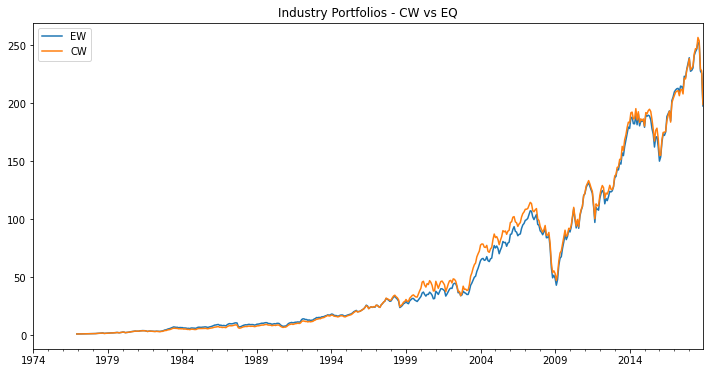

In [14]:
backtest_weights = pd.DataFrame({"EW": ew_returns, "CW": cw_returns})
(1+backtest_weights).cumprod().plot(figsize=(12,6), title= "Industry Portfolios - CW vs EQ")
kit.summary_stats(backtest_weights.dropna())

There is not much difference here. The reason *could be* because here I am taking 49 equally weighted portfolios and then cap weighting that. So the granularity is not enough to see that much of a difference, because the constituents themselves of eaach one of those sector portfolios are already equally weighted.

We can backtest any weighting scheme.

Now, I will add one more weighting function: the **GMV - Global Minimum Variance portfolio**. 

I can build several portfolios using the same weighting scheme with minimum volatility, but minimum volatility requires an estimate of the covariance matrix. So to build different portfolios, I will fix the weighting scheme as GMV and will give it covariance matrix parameters from different covariance estimators.

### Building the Global Minimum Variance Portfolio

In [16]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns.
    """
    return r.cov()


def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matix of the returns.
    """
    est_cov = cov_estimator(r, **kwargs)
    return kit.gmv(est_cov)

In [17]:
def gmv(cov):
    """
    Returns the weight of the Global Minimum Volatility portfolio given covariance matrix
    """
    number_of_assets = cov.shape[0]
    #riskfree rate is not going to get used. For expected return, it really doesnt matter what number you give.
    return max_Sharpe_ratio(0, np.repeat(1, number_of_assets), cov)

The back tester requires a weighting scheme function. Here the weighting function is GMV. The weighting function requires a function to compute the covariance. The covariance estimator in this case is sample estimator.

In [34]:
gmv_sample_returns = kit.backtest_ws(ind_returns, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
backtest_returns = pd.DataFrame({"EW": ew_returns, "CW": cw_returns, "GMV-sample": gmv_sample_returns})

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.134043,0.187685,-0.523820,5.789868,0.081739,0.119803,0.539330,-0.588310
GMV-sample,0.159490,0.097030,-0.530871,5.054765,0.036142,0.055959,1.298896,-0.332077


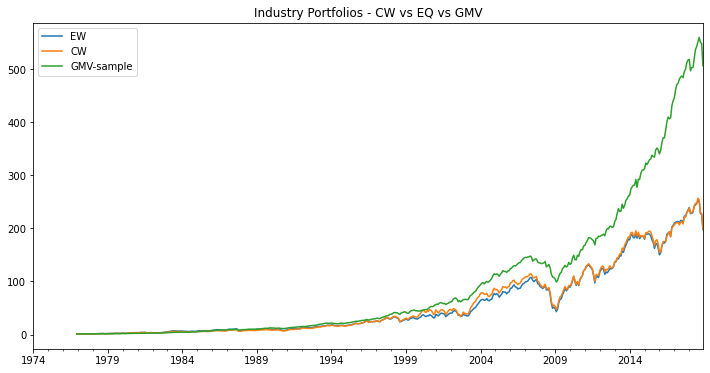

In [35]:
# Convert to wealth index and plot
(1+backtest_returns).cumprod().plot(figsize=(12,6), title= "Industry Portfolios - CW vs EQ vs GMV")
kit.summary_stats(backtest_returns.dropna())

It can be seen that the volatility of the equally weighted and cap weighted portfolios are almost the same. The volatilty for GMV portfolio is almost half that of CW and EW portfolios. The drawdown is also 33% compared to 59-58% for EW-CW portfolios. The Sharpe Ratio is large because of the excess return and the decrease in volatility.

Now I'll try another estimator - ***Constant Correlation***. Take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlation $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt {\sigma_{ii} \sigma_{jj} } } $$

In [36]:
def constant_correlation_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation Model.
    """
    
    rhos = r.corr()
    n = rhos.shape[0]
    # This is a symmetric matrix with all diagonals = 1
    # So the mean correlation matri is the sum of all elements minus the number of elements in diagonal 
    # [average of off-diagonal elements]
    rho_bar = (rhos.values.sum()-n) /(n*(n-1))
    # Reconstruct a new crrelation matrix with the mean values
    ccor = np.full_like(rhos, rho_bar)
    # Diagonal values should be 1
    np.fill_diagonal(ccor, 1)
    sd = r.std()
    
    ## regenerate the covariance matrix. There are two ways of doing it, one with the statsmodels package
#     import statsmodels.stats.moment_helpers as mh
#     ccov = mh.corr2cov(ccor, sd)
    ccov = ccor * np.outer(sd, sd)
    
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)
    

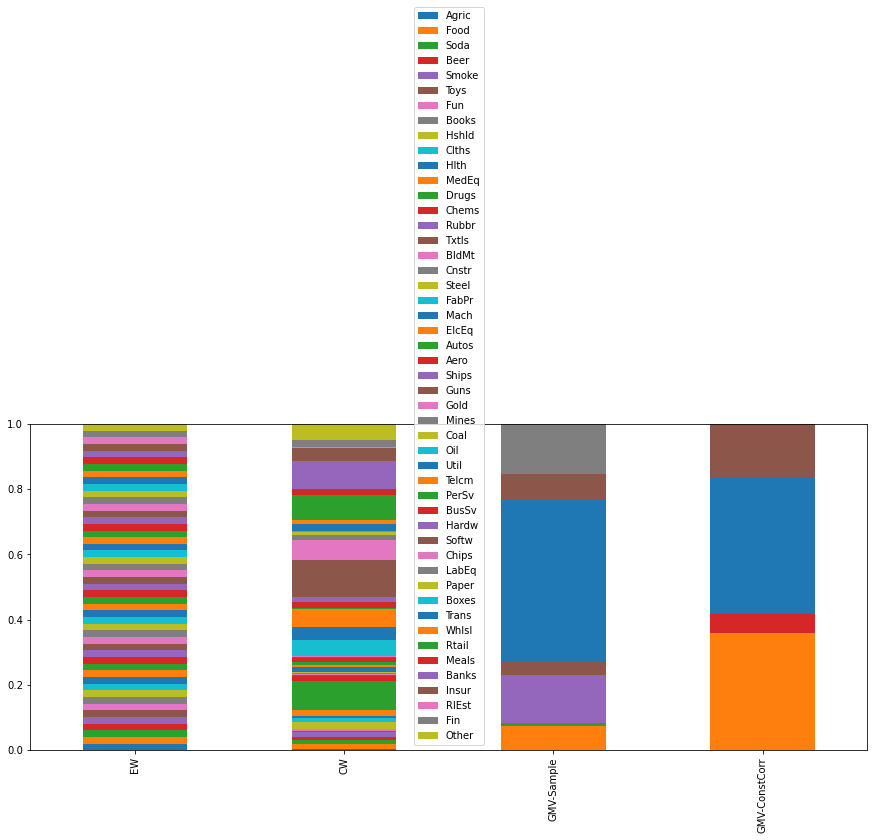

In [37]:
weights = pd.DataFrame(
{
    "EW": kit.weight_ew(ind_returns["2016":]),
    "CW": kit.weight_cw(ind_returns["2016":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_returns["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_returns["2016":], cov_estimator=constant_correlation_cov)
}
)
weights.T.plot.bar(stacked=True, figsize=(15,6), legend=True)

It is interesting to see the weights of stocks with different weighing schemes.

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.134043,0.187685,-0.523820,5.789868,0.081739,0.119803,0.539330,-0.588310
GMV-sample,0.159490,0.097030,-0.530871,5.054765,0.036142,0.055959,1.298896,-0.332077
GMV-CC,0.141793,0.102668,-0.500365,4.458260,0.040353,0.061776,1.059751,-0.421379


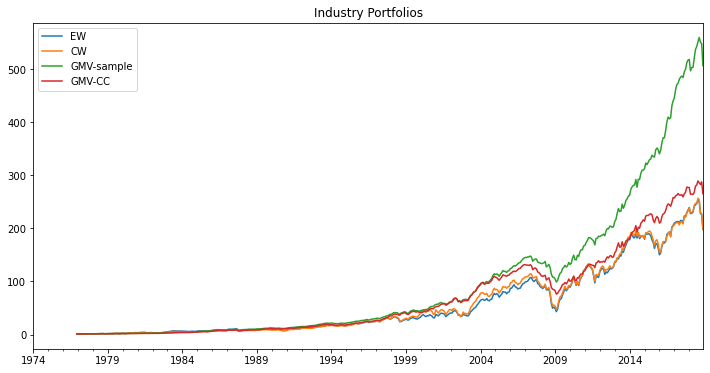

In [40]:
gmv_constcorr_returns = kit.backtest_ws(ind_returns, estimation_window=36, weighting=weight_gmv, cov_estimator=constant_correlation_cov)
backtest_returns = pd.DataFrame({"EW":ew_returns, "CW":cw_returns, "GMV-sample": gmv_sample_returns, "GMV-CC":gmv_constcorr_returns})
(1+backtest_returns).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
kit.summary_stats(backtest_returns.dropna())

In this example, the constant correlation matrix really didn't have that much of an improvement. The volatility amost as same as the sample covariance matrix. 

Portfolios are being considered here and not individual stocks. When working with portfolios, a lot of the noise has already been wiped out. A lot of idiosyncratic volatilies get removed in portfolios as opposed to stocks and it shows more cohesive behaviour. 

If these techniques are used with individual stocks, very very significant benefits can be seen.

## Statistical Shrinkage

The idea of shrikage was introduced between two different estimates. We can mix the model and sample estimates by choosing a shrinkage parameter. EWe can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practictioners choose 0.5. 

A simple shrinkage based covariance estimator is implemented that shrinks towards the Constant Correlation Estimate.

In [42]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators.
    """
    prior = constant_correlation_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

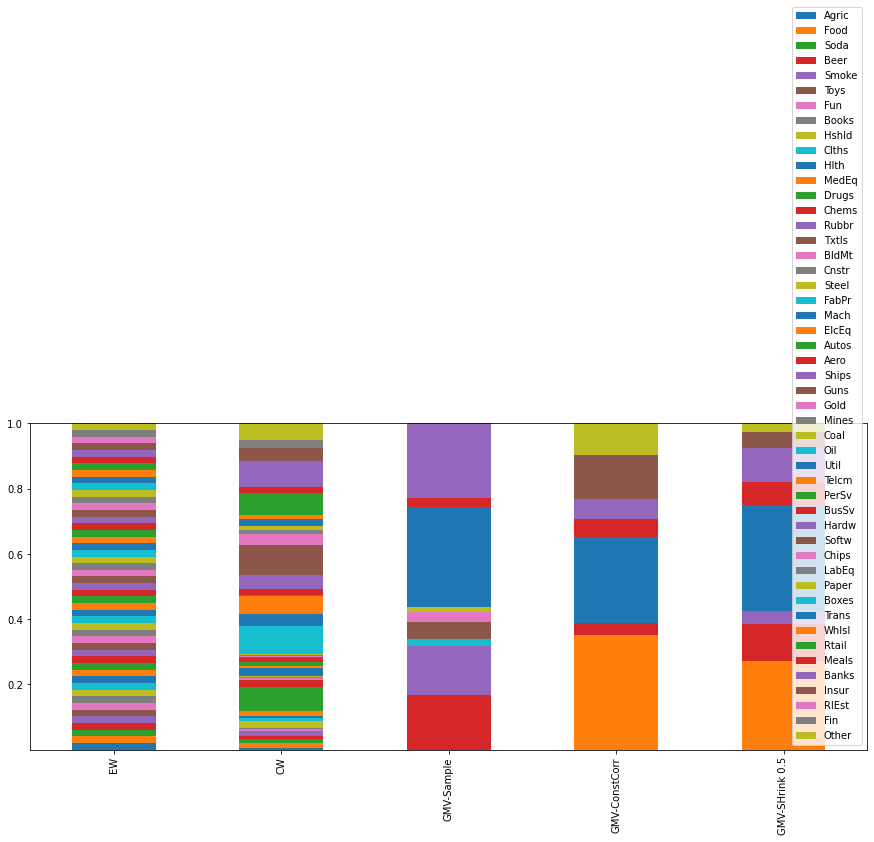

In [43]:
weights = pd.DataFrame(
{
    "EW": kit.weight_ew(ind_returns["2013":]),
    "CW": kit.weight_cw(ind_returns["2013":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_returns["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_returns["2013":], cov_estimator=constant_correlation_cov),
    "GMV-SHrink 0.5": weight_gmv(ind_returns["2013":], cov_estimator=shrinkage_cov)
}
)
weights.T.plot.bar(stacked=True, figsize=(15,6), legend=True)

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.133872,0.187733,-0.613456,6.736417,0.082009,0.122226,0.538298,-0.598060
CW,0.134043,0.187685,-0.523820,5.789868,0.081739,0.119803,0.539330,-0.588310
GMV-sample,0.159490,0.097030,-0.530871,5.054765,0.036142,0.055959,1.298896,-0.332077
GMV-CC,0.141793,0.102668,-0.500365,4.458260,0.040353,0.061776,1.059751,-0.421379
GMV-Shrink 0.5,0.147693,0.099441,-0.525134,4.718871,0.038352,0.059434,1.151909,-0.409054


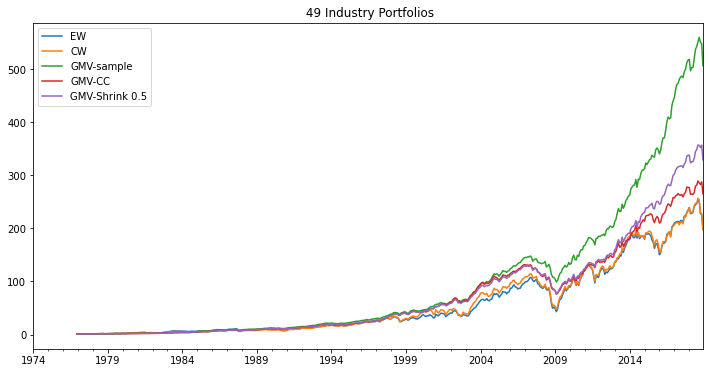

In [46]:
gmv_shrinkage_returns = kit.backtest_ws(ind_returns, estimation_window=36, weighting=weight_gmv,
                                        cov_estimator=shrinkage_cov, delta=0.5)
backtest_returns = pd.DataFrame({"EW":ew_returns, "CW":cw_returns, "GMV-sample": gmv_sample_returns, 
                                 "GMV-CC":gmv_constcorr_returns, "GMV-Shrink 0.5": gmv_shrinkage_returns
                                })
(1+backtest_returns).cumprod().plot(figsize=(12,6), title=" 49 Industry Portfolios")
kit.summary_stats(backtest_returns.dropna())